In [2]:
from cyvcf2 import VCF
import pandas as pd
import numpy as np
import math
import pysam
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
######## Reading TRGT and HipSTR VCF records on HG002 whole genome and merging them ########
n_total = 937122 

trgt = VCF("HG002__wg_trgt_hg38.sorted.vcf.gz")


trgt_records = []
trgt_cnt = 0
for record in trgt:
    AL = record.format("AL")[0]
    GB = [A - len(record.REF) for A in AL]
    allele_seqs = record.gt_bases[0].split("/")
    if "." in allele_seqs[0]:
        continue
    trgt_cnt += 1
    trgt_records.append([record.CHROM, record.POS, record.REF, record.INFO['TRID'], GB, allele_seqs])

    
hipstr_records = []    
cnt = 0
for chrom in [x for x in range(1,23)] + ['X', 'Y']:
    hipstr = VCF(f"HG002_wg_hipstr_adotto_dec12_chr{chrom}.vcf.gz")
    for record in hipstr:
        GB = record.format("GB")[0]
        if GB == ".":
            continue
        GB = GB.split("|")        
        GB = [int(g) for g in GB]
        allele_seqs = record.gt_bases[0].split("|")
        if "." in allele_seqs[0]:
            continue
        cnt += 1   
        hipstr_records.append([record.CHROM,record.POS, 
                               record.INFO['END'], record.REF, 
                               record.ID, GB, record.INFO['DP'], record.INFO['PERIOD'], allele_seqs])
    
    
hipstr_df = pd.DataFrame(hipstr_records, columns = ['CHROM','POS','END', 'REF', 'ID', 
                                                    'AL','DP','PERIOD', 'AL_SEQ'])

trgt_df = pd.DataFrame(trgt_records, columns = ['CHROM','POS','REF', 'ID', 'AL', 'AL_SEQ'])

both = pd.merge(hipstr_df, trgt_df, on = ['CHROM',"ID"], suffixes = ["_hipstr", "_trgt"], how='outer')

print(f"TRGT genotyped {round(trgt_cnt/n_total*100, 2)}% of loci where LongTR genotyped {round(cnt / n_total*100,2)}% of loci")

TRGT genotyped 99.83% of loci where HipSTR genotyped 99.77% of loci


In [4]:
######## Compare length and sequence ########

def compare_gt(al1, al2, period):
    if type(al1) != list or type(al2) != list:
        return np.nan
    al1.sort()
    al2.sort()
    if len(al1) == 2 and len(al2) == 2:
        if al1[0] == al2[0] and al1[1] == al2[1]:
            return "same"
        if abs(al1[0] - al2[0]) <= period  and abs(al1[1] - al2[1]) <= period:
            return "almost same"
        else:
            return "different"
    if len(al1) == 1 and len(al2) == 1:
        if al1[0] == al2[0]:
            return "same"
        if abs(al1[0] - al2[0]) <= period:
            return "almost same"
        else:
            return "different"
    else:
        print("wrong genotype length")
        

both['compare'] = both.apply(lambda row: compare_gt(row['AL_hipstr'], row['AL_trgt'], row['PERIOD']), axis = 1)
print(f"% of calls exactly same length between TRGT and HipSTR: {round(len(both[both['compare'] == 'same']) /len(both[~both['compare'].isna()])*100,2)}")
print(f"% of calls off by at most one between TRGT and HipSTR: {round(len(both[both['compare'] != 'different']) /len(both[~both['compare'].isna()])*100,2)}")

% of calls exactly same length between TRGT and HipSTR: 86.09
% of calls off by at most one between TRGT and HipSTR: 97.87


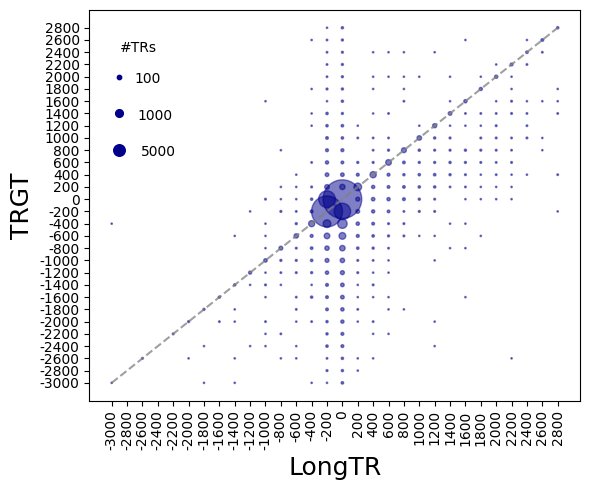

In [22]:

def bubble_df_maker(bubble_data,limit,step,tool_1,tool_2):
    keys = []
    for i in range(-limit,limit,step):
        for j in range(-limit,limit,step):
            keys.append((i,j))
    bubble_intervals = {k:0 for k in keys}

    upper_limits = 0
    for index,row in bubble_data.iterrows():
        if abs(row[tool_1]) > limit or abs(row[tool_2]) > limit:
            upper_limits += 1
            continue
        x = math.floor(row[tool_1] / step ) * step
        y = math.floor(row[tool_2] / step ) * step
        bubble_intervals[(x,y)] += 1
    bubble_df = pd.DataFrame(bubble_intervals.items(), columns=['Interval', 'size'])
    bubble_df['Interval'] = bubble_df['Interval'].astype(str).str.replace("(","")
    bubble_df['Interval'] = bubble_df['Interval'].str.replace(")","")
    bubble_df[['x','y']] = bubble_df['Interval'].str.split(",",expand = True)
    return bubble_df

def bubble_plot(bubble_df, limit, step, legend_values,period,tool_name_1,tool_name_2):
    dis = 1
    scale = 1000/np.mean(list(bubble_df['size']))

    fig, ax = plt.subplots(figsize=(6,5),dpi=100)
    ax.scatter(bubble_df['x'], bubble_df['y'],
                           s=np.sqrt(bubble_df['size']*scale),
                           color="darkblue",
                           alpha=0.5)
    ax.set_xlabel(tool_name_1, size=18)
    ax.set_ylabel(tool_name_2, size=18)
    ax.plot([0, 2*limit/step - 1], [0, 2*limit/step - 1], linestyle="dashed", color="gray", alpha=0.75)  
    ax.set_xticks(ax.get_xticks()[::dis])
    ax.set_yticks(ax.get_yticks()[::dis])
    ax.set_xticklabels(np.arange(-limit, limit, dis*step), rotation=90)
    ax.set_yticklabels(np.arange(-limit, limit, dis*step))
    ax.annotate("#TRs", xy=(0.5,2*limit/step - 3))
    for i, val in enumerate(legend_values):
        xval = 0.5
        yval = 2*limit/step - 5 - 3*i
        ax.scatter([xval], [yval], color="darkblue", s=np.sqrt(val*scale))
        ax.annotate(val, xy=(xval+1+0.2*i,yval-0.5))
    fig.tight_layout()
    plt.savefig("TRGT_vs_LongTR.pdf", dpi=1200)

def dif_mean_len(GB_hipstr, GB_TRGT):    
    return np.mean(GB_hipstr), np.mean(GB_TRGT)

both = both.dropna()
both[['HipSTR_mean', 'TRGT_mean']] = both.apply(lambda row: dif_mean_len(row['AL_hipstr'], 
                                                                         row['AL_trgt']), axis = 1,
                                                                                 result_type='expand')
bubble_df = bubble_df_maker(both, 3000, 200,'HipSTR_mean', 'TRGT_mean')
bubble_plot(bubble_df,3000,200,[100,1000,5000],"", "LongTR", "TRGT")

In [5]:
both_with_calls = both[~both['compare'].isna()]
both_with_calls[both_with_calls['AL_SEQ_hipstr'].apply(lambda x: "<DEL>" in x)]

,CHROM,POS_hipstr,END,REF_hipstr,ID,AL_hipstr,DP,PERIOD,AL_SEQ_hipstr,POS_trgt,REF_trgt,AL_trgt,AL_SEQ_trgt,compare
5538,chr1,13238184.0,13238260.0,AGTGGCCATCCGACACTTGGCCACTCTTTTTTTTTTTTTTTTTTTT...,chr1_13238184_13238260_T,"[-77, -10]",49.0,1.0,"[<DEL>, AGTGGCCATCCGACACTTGGCCACTCTTTTTTTTTTTT...",13238185.0,GTGGCCATCCGACACTTGGCCACTCTTTTTTTTTTTTTTTTTTTTT...,"[-10, 1]",[GTGGCCATCCGACACTTGGCCACTCTTTTTTTTTTTTTTTTGACA...,different
5539,chr1,13239430.0,13239522.0,TGGGTGACAGAGCCAGAATCCATCTCAAAAAAAAAAAAAAAAAAGA...,chr1_13239430_13239522_AAAAAAGAAAAAA,"[-93, -1]",46.0,13.0,"[<DEL>, TGGGTGACAGAGCCAGAATCCATCTCAAAAAAAAAAAA...",13239431.0,GGGTGACAGAGCCAGAATCCATCTCAAAAAAAAAAAAAAAAAAGAA...,"[-1, 0]",[GGGTGACAGAGCCAGAATCCATCTCAAAAAAAAAAAAAAAAAAGA...,different
5540,chr1,13239766.0,13239949.0,ACAGAGTGAGAATCTGTGTGAAAGAAAGAAAGAGAGAGGGAGAGAG...,chr1_13239766_13239949_AGAAA,"[-184, -15]",46.0,5.0,"[<DEL>, ACAGAGTGAGAATCTGTGTGAAAGAAAGAAAGAGAGAG...",13239767.0,CAGAGTGAGAATCTGTGTGAAAGAAAGAAAGAGAGAGGGAGAGAGG...,"[-35, -20]",[CAGAGTGAGAATCTGTGTGAAAGAAAGAAAGAGAGAGGGAGAGAG...,different
7099,chr1,16745773.0,16745839.0,AAAAAAAAAAAAAAAAAAAAACAGAGAGAGAGAGAGAAATTTGGTT...,chr1_16745773_16745839_A,"[-67, -10]",46.0,1.0,"[<DEL>, AAAAAAAAAAAAAGAGAGAGAGAGAGAAATTTGGTTTT...",16745774.0,AAAAAAAAAAAAAAAAAAAACAGAGAGAGAGAGAGAAATTTGGTTT...,"[-10, -3]",[AAAAAAAAAAAAGAGAGAGAGAGAGAAATTTGGTTTTCGAACCAG...,different
7100,chr1,16745961.0,16746062.0,TTGAGAAATATTGAGGAGGCTTTGTCTCTTTCACCTCCAACTGCTC...,chr1_16745961_16746062_CTCCTTCTC,"[-102, 0]",48.0,9.0,"[<DEL>, TTGAGAAATATCGAGGAGGCTTTGTCTCTTTCACCTCC...",16745962.0,TGAGAAATATTGAGGAGGCTTTGTCTCTTTCACCTCCAACTGCTCC...,"[0, 0]",[TGAGAAATATTGAGGAGGCTTTGTCTCTTTCACCTCCAACTGCTC...,different
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898705,chr22,33385502.0,33385579.0,TGGACGACAGCGCAGGACACCGTCTCAAAAAAAAAAAAAAAAAAAA...,chr22_33385502_33385579_AAAAAAACT,"[-78, 0]",11.0,9.0,"[<DEL>, TGGACGACAGCGCAGGACACCGTCTCAAAAAAAAAAAA...",33385503.0,GGACGACAGCGCAGGACACCGTCTCAAAAAAAAAAAAAAAAAAAAA...,"[-1, 0]",[GGACGACAGCGCAGGACACCGTCTCAAAAAAAAAAAAAAAAAAAA...,different
902985,chr22,42705573.0,42705663.0,AGCCTGGGCGACAGAGATTCTGTCTCAAAAAAAAAAAAAAGAAAAA...,chr22_42705573_42705663_AAAAAAAAAAAAAAGAAAAAG,"[-91, -91]",26.0,21.0,"[<DEL>, <DEL>]",42705574.0,GCCTGGGCGACAGAGATTCTGTCTCAAAAAAAAAAAAAAGAAAAAG...,"[-11, -11]",[GAAACCCAGAGAACTGTCCTGGCTTCTCTCCCAATTTCCACCAAA...,different
902986,chr22,42706022.0,42706095.0,CCAGCCTGGGTGACACAGACTACATCTCAAAAAAAAAAAAAAAAAA...,chr22_42706022_42706095_A,"[-74, -74]",26.0,1.0,"[<DEL>, <DEL>]",42706023.0,CAGCCTGGGTGACACAGACTACATCTCAAAAAAAAAAAAAAAAAAA...,"[137, 138]",[CAGCCTGGGTGACAGAGCGAGACTCCATCTCAAAAAAAAAAAAAA...,different
904266,chr22,45479307.0,45479368.0,GGCGCCCGCCACCGCGCCCGGCTAATTTTTTTTTTTTGTATTTTTA...,chr22_45479307_45479368_T,"[-62, -1]",24.0,1.0,[GGCGCCCGCCACCGCGCCCGGCTAATTTTTTTTTTTGTATTTTTA...,45479308.0,GCGCCCGCCACCGCGCCCGGCTAATTTTTTTTTTTTGTATTTTTAG...,"[-1, 126]",[GCGCCCGCCACCGCGCCCGGCTAATTTTTTTTTTTGTATTTTTAG...,different


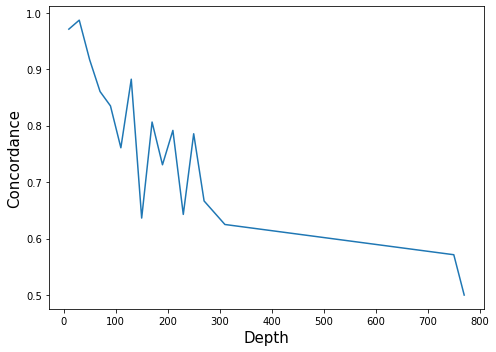

In [6]:
MINLEN = 10
MAXLEN = 1000


fig = plt.figure()
fig.set_size_inches((7, 5))
ax = fig.add_subplot(111)


lenbins = range(MINLEN, MAXLEN+1,20)
xvals = []
yvals = []
for j in range(len(lenbins)-1):
    lb = lenbins[j]
    ub = lenbins[j+1]
    xx = both[(both['DP']>=lb) & (both['DP']<ub)]

    if len(xx) > 5:
        xvals.append(lb)
        yvals.append(len(xx[xx['compare'] != 'different'])/len(xx))
ax.plot(xvals, yvals)
ax.set_xlabel("Depth", size=15)
ax.set_ylabel("Concordance", size=15)
fig.tight_layout()
plt.savefig("concordance_vs_dp.pdf", dpi=1200)
#     if lencol == "lencol":
#         ax.set_xlabel("Length", size=LABSIZE)
#     else:
#         ax.set_xlabel("Length (bp)", size=LABSIZE)
#     ax.set_ylabel("Num. TRs", size=LABSIZE)
#     plt.yscale("log")
#     ax.legend(loc="lower right")
#     ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=TICKSIZE)
#     ax.set_yticklabels(ax.get_yticklabels(), size=TICKSIZE)
#     if figname is not None and ax is None: fig.savefig(figname)